In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample as ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Model Selection

When modeling any kind of data, not only timeseries, the *final* model is unknown. Actually, given $n$ covarites the number of possible models is given by $2^n$.

In this notebook, we will explore three different options to arrive to the final model:
* Using information criteria models, e.g., AIC and BIC
* Using a performance metric in an out-of-sample test
* Looking into ACF and PACF plots 

Note, the first two approaches are general, i.e. they can be used for other modeling techniques and not only for timeseries. On the other hand, the last approach is only for timeseries data.

In [3]:
# load the dataset from the course's repo
url = 'https://raw.githubusercontent.com/BI-DS/EBA-3530/main/Lecture_3/timeseries_choosing_q.csv'
y = pd.read_csv(url, delimiter=',',header=None).values
print('The size of the timeseries is {}'.format(y.shape[0]))

The size of the timeseries is 1000


As usual, let's look at some plots ....

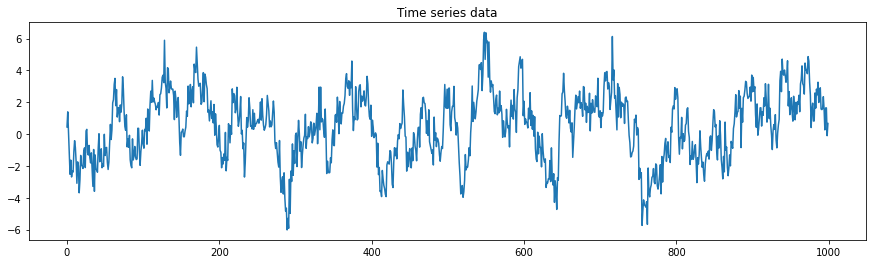

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


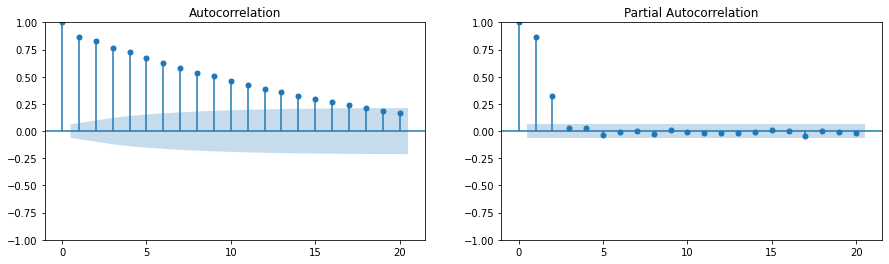

In [4]:
fig = plt.figure(figsize=(15,4))
plt.title('Time series data')
plt.plot(y)
plt.show()
fig, axs = plt.subplots(1,2,figsize=(15,4))
plot_acf(y, lags=20, ax=axs[0])
plot_pacf(y, lags=20, ax=axs[1])
plt.show()

## Define the models to be explored
Let's consider the following five competitive models:
* M1: $y_t = y_{t-1} + e_t$
* M2: $y_t = y_{t-1} +y_{t-2} + e_t$
* M3: $y_t = y_{t-1} +y_{t-2} +y_{t-3}+ e_t$
* M4: $y_t = y_{t-1} +y_{t-2} +y_{t-3} +y_{t-4} + e_t$
* M5: $y_t = y_{t-1} +y_{t-2} +y_{t-3} +y_{t-4} +y_{t-5} + e_t$

In [5]:
# define all 5 models in a list with tupples
# each tuple specifies the number of lags in 
# the AR process
orders = [(1,0,0),(2,0,0),(3,0,0),(4,0,0),(5,0,0)]

## 1) Information Criteria approach

In [6]:
all_aic = []
all_bic = []

# loop through the 5 models
for i,order in enumerate(orders):
  # define and fit AR model
  model = ARIMA(y,order=order).fit()
  # get AIC and BIC from the fitted model
  all_aic.append(model.aic)
  all_bic.append(model.bic)
  
  print('Model with {0} lag has AIC {1:.3f} and BIC {2:.3f}'\
        .format(i+1,model.aic, model.bic))

print('The winner model accordig with AIC is {} !!!'\
      .format(orders[np.argmin(all_aic)]))
print('The winner model accordig with BIC is {} !!!'\
      .format(orders[np.argmin(all_bic)]))

Model with 1 lag has AIC 2962.559 and BIC 2977.283
Model with 2 lag has AIC 2856.605 and BIC 2876.237
Model with 3 lag has AIC 2857.858 and BIC 2882.396
Model with 4 lag has AIC 2859.268 and BIC 2888.715
Model with 5 lag has AIC 2860.057 and BIC 2894.411
The winner model accordig with AIC is (2, 0, 0) !!!
The winner model accordig with BIC is (2, 0, 0) !!!


##2) Out-of-sample performance
For this method, I choose to use the last 50 observations to test the out-of-sample performance for each of the five competitive models, i.e. the first 950 observations are used for model training. 

Further, I choose two performance metrics:
* mean square error (mse)
* root mean square error (rmse)

In [10]:
# define train and test data sets
no_obs_tr = 950
y_tr = y[:no_obs_tr]
y_te = y[no_obs_tr:]
all_mse = []
all_rmse = []

# loop through the 5 diff models
for i,order in enumerate(orders):
  # define and fit AR model
  model = ARIMA(y_tr, order=order).fit()

  # Forecast
  horizon = y_te.shape[0]
  y_hat = model.get_forecast(horizon).summary_frame()['mean'].values
  
  #calculate mse and rmse
  mse = np.mean((y_hat - y_te)**2)
  rmse = np.mean((y_hat - y_te)**2)**0.5
  
  # save metrics
  all_mse.append(mse)
  all_rmse.append(rmse)
  print('Model with {0} lag has mse {1:.3f} and rmse {2:.3f}'\
        .format(i+1,mse,rmse))
  
print('The winner model accordig with mse is {} !!!'\
      .format(orders[np.argmin(all_mse)]))
print('The winner model accordig with rmse is {} !!!'\
      .format(orders[np.argmin(all_rmse)]))

Model with 1 lag has mse 4.386 and rmse 2.094
Model with 2 lag has mse 3.753 and rmse 1.937
Model with 3 lag has mse 3.711 and rmse 1.926
Model with 4 lag has mse 3.631 and rmse 1.905
Model with 5 lag has mse 3.748 and rmse 1.936
The winner model accordig with mse is (4, 0, 0) !!!
The winner model accordig with rmse is (4, 0, 0) !!!


**Question:** define different values for `no_obs_tr` in a list and create a loop to go trough each of the values and run the loop defined above. Do the results change?

**Tips:** You will have two loops like this:

```
for n in no_obs_tr:
  #here you define y_tr and y_te using n
  for i,order in enumerate(orders):
```


## 3) ACF and PACF
This approach only applies to timeseries models, e.g. AR, MA or ARMA. 

According with *Shumway, R. H., Stoffer, D. S., & Stoffer, D. S. (2000). Time series analysis and its applications (Vol. 3). New York: springer*, we can select the number of lags (p) in an autoregressive (AR) model by looking into the autocorrelation function (ACF) and the partial autocorreltation function (PACF).

As shown by the table below, an AR process shows ACFs that tails off. In other words, the ACF decreases gradually. On the other hand, the PACF for an AR process cuts off after lag p. That is, becomes zero in statistical terms.  

|     | AR(p) |
| --- | ---   |
| ACF | Tails off |
| PACF| Cuts off after lag p|

So let's look again at the ACF and PACF for the time series in this exercise

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


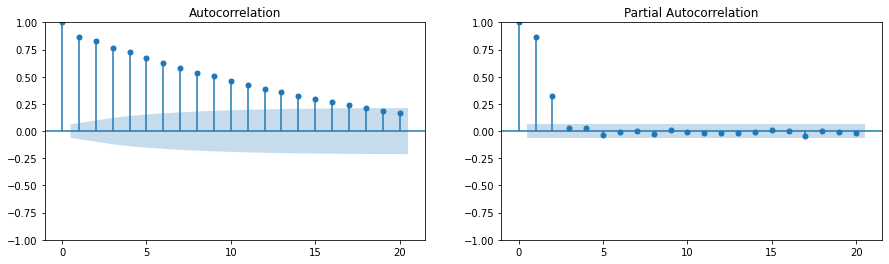

In [11]:
# plot the first 20 lags
fig, axs = plt.subplots(1,2,figsize=(15,4))
plot_acf(y, lags=20, ax=axs[0])
plot_pacf(y, lags=20, ax=axs[1])
plt.show()

The ACF (left diagram) clearly tails off and the PACF (right diagram) becomes 0 after lag 2.

**Question:** What do these results suggest?